In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
from scipy.stats import entropy
import torch
import time
from sbi.inference.base import infer
from sbi import inference
import sbi.utils as utils
from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode
import seaborn as sns
from numba import jit

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import import_ipynb
from function_for_features import events_counter, features_series, Peak_pos

In [56]:
def calculate_summary_statistics(v,th):
    peak_pos = Peak_pos(v)
    #print(peak_pos)
    events = events_counter(peak_pos,th)
    fetures_dict = features_series(events,v,peak_pos)
    N = len(fetures_dict)
    #print(N)
    features = np.zeros(N)
    #print(features)
    i = 0
    for t in fetures_dict:
        features[i] = fetures_dict[t]
        i += 1
    return features

In [133]:
def _Damien_model(params):
    t_init = 0
    t_final = 10000
    dt = 0.01
    gamma=0.04
    epsilon=0.01
    ts = np.arange(t_init,t_final,dt)
    v_0 = -78.0
    n_inf = 1.0 / (1.0 + np.exp((-19.0 - v_0) / 18.0))
    z0 = np.array([-78.0, n_inf, -0.6, 0.8])
    Np = 10000
    t = np.linspace(0, Np, int(Np / 0.01))
    v = np.zeros_like(t)
    n = np.zeros_like(t)
    DK_i = np.zeros_like(t)
    Kg = np.zeros_like(t)
    Cm = 1.0
    tau_n = 0.25

    w_i = 2160.
    w_o = 720.
    rho = 250.
    beta = w_i / w_o

    K_bath = params

    Na_i0 = 16.0
    Na_o0 = 138.0
    K_i0 = 140.0
    K_o0 = 4.80
    Cl_o0 = 112.0
    Cl_i0 = 5.0
    g_Cl = 7.5
    g_Na = 40.0
    g_K = 22.0
    g_Nal = 0.02
    g_Kl = 0.12
    v[0] = z0[0]
    n[0] = z0[1]
    DK_i[0] = z0[2]
    Kg[0] = z0[3]

    for i in range(1, ts.shape[0]):
        DNa_i = -DK_i[i - 1]
        DNa_o = -beta * DNa_i
        DK_o = -beta * DK_i[i - 1]
        K_i = K_i0 + DK_i[i - 1]
        Na_i = Na_i0 + DNa_i
        Na_o = Na_o0 + DNa_o
        K_o = K_o0 + DK_o + Kg[i - 1]

        m_inf = 1.0 / (1.0 + np.exp((-24.0 - v[i - 1]) / 12.0))
        n_inf = 1.0 / (1.0 + np.exp((-19.0 - v[i - 1]) / 18.0))
        h_n = 1.1 - 1.0 / (1.0 + np.exp(-8.0 * (n[i - 1] - 0.4)))

        I_Na = (g_Nal + g_Na * m_inf * h_n) * (v[i - 1] - 26.64 * np.log(Na_o / Na_i))
        I_K = (g_Kl + g_K * n[i - 1]) * (v[i - 1] - 26.64 * np.log(K_o / K_i))
        I_Cl = g_Cl * (v[i - 1] + 26.64 * np.log(Cl_o0 / Cl_i0))
        I_pump = rho * (1.0 / (1.0 + np.exp((21.0 - Na_i) / 2.0))) * (1.0 / (1.0 + np.exp((5.5 - K_o))))

        dv = (-1.0 / Cm) * (I_Cl + I_Na + I_K + I_pump)
        dn = (n_inf - n[i - 1]) / tau_n
        dDK_i = -(gamma / w_i) * (I_K - 2.0 * I_pump)
        dKg = epsilon * (K_bath - K_o)

        v[i] = v[i - 1] + dt * dv
        n[i] = n[i - 1] + dt * dn
        DK_i[i] = DK_i[i - 1] + dt * dDK_i
        Kg[i] = Kg[i - 1] + dt * dKg

    return np.concatenate((v, n, DK_i, Kg))


In [134]:
ode_Damien_model = jit(_Damien_model)

In [19]:
def Damien_model_Wrapper(params):

    params_ = np.asarray(params)
    V = -78.0
    n_inf = 1.0 / (1.0 + np.exp((-19.0 - V) / 18.0))
    z0 = np.array([V, n_inf, -0.6, 0.8])
    t_init = 0
    t_final = 10000
    dt = 0.01
    
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]

    v = ode_Damien_model(params_[0])[0:nt]#,ts,dt)[0:nt]
    
    summstats = torch.as_tensor(calculate_summary_statistics(v.reshape(-1), th= 0.00012))
    
    return summstats

In [49]:
prior_min = [7.5]
prior_max = [25.0]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [50]:
prior.sample()   



tensor([21.1064])

In [51]:
prior.sample().tolist()

[22.669658660888672]

In [52]:
prior_samples=np.stack([prior.sample().tolist() for _ in range(1000)], axis=0)
prior_samples.shape

(1000, 1)

In [53]:
num_params=prior.sample().shape[0]
num_params

1

In [119]:
num_sims=100


In [135]:
start_time = time.time()
posterior = infer(Damien_model_Wrapper, prior, method='SNPE', num_simulations=num_sims, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100 simulations.: 100%|██████████| 100/100 [05:12<00:00,  3.13s/it]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sbi/neural_nets/flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 183 epochs.------------------------------------------------------------
--- 318.33553314208984 seconds ---


In [136]:
params_label=np.array(['$\K$'])

Plot the membrane potential v and firing rate r

In [137]:
v_0 = -78.0
n_inf = 1.0 / (1.0 + np.exp((-19.0 - v_0) / 18.0))
z0 = [-78.0, n_inf, -0.6, 0.8]
t_init = 0
t_final = 10000
dt = 0.01
ts = np.arange(t_init,t_final,dt)
nt=ts.shape[0]
K_true=7.5
true_params = np.array([K_true])

In [138]:
x_obs = ode_Damien_model(true_params[0])
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), th= 0.00012)

In [139]:
print(x_obs_summary_statistics)

[ 2.15219382e+01 -1.16714248e+01 -1.46600875e+01  3.83707467e+00
  9.98438118e-01 -2.23591660e+01  1.53329794e+01  2.15738716e+00
  2.15620933e+00  7.99503036e+05  4.25097087e+06  5.00000000e-06
  5.50000000e-05  5.00522500e+04  2.08950188e+05  7.39400000e+04]


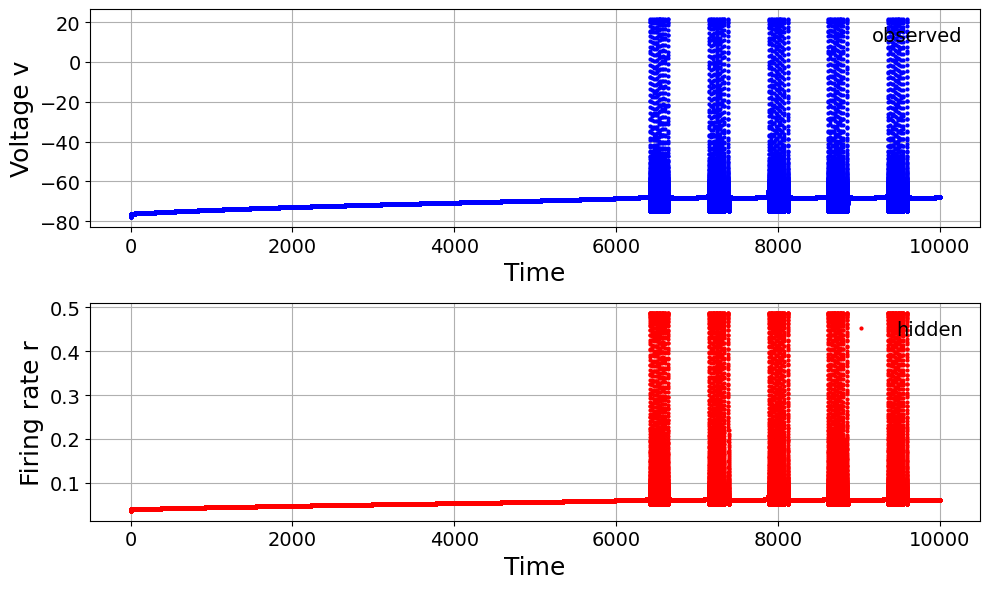

In [140]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.show()

POSTERIOR SAMPLING

In [141]:
num_samples=100

In [142]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

print ("-"*60)
print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 100 posterior samples: 127it [00:00, 10667.61it/s]            

------------------------------------------------------------
--- posterior sampling took: 0.014952898025512695 seconds ---


In [143]:
posterior_samples.shape

(100, 1)

In [144]:
K_est= posterior_samples[:,0]

In [145]:
print("K_est=", K_est.mean())

K_est= 7.8014936


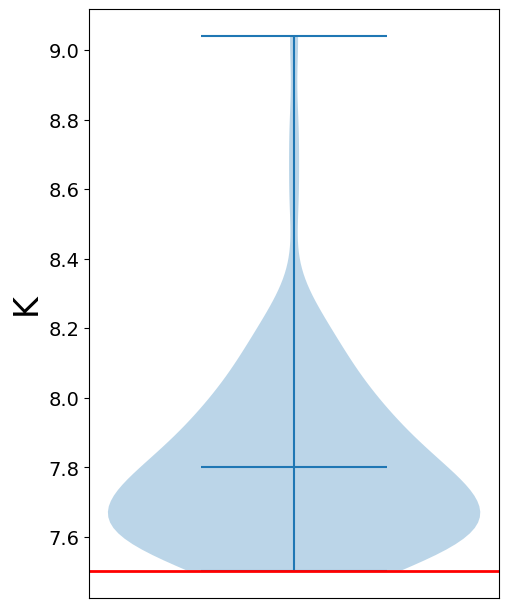

In [146]:
plt.figure(figsize=(5, 6))
for i, variables in enumerate([K_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel('K', fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

/var/folders/f_/vz2y3w_54sq9k8wdn2b176640000gn/T/ipykernel_71309/191222992.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},


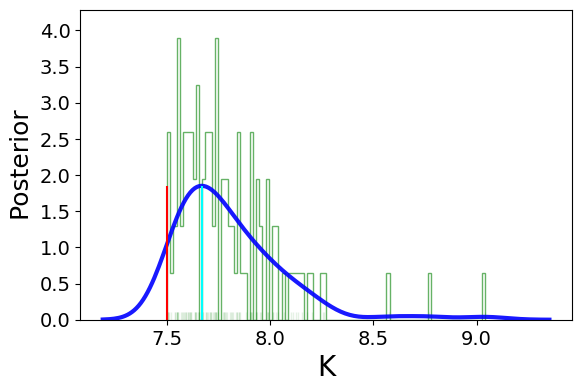

In [147]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                 kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                 label='SBI')

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel('K', fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.show()

/var/folders/f_/vz2y3w_54sq9k8wdn2b176640000gn/T/ipykernel_71309/4051126243.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
/var/folders/f_/vz2y3w_54sq9k8wdn2b176640000gn/T/ipykernel_71309/4051126243.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, pleas

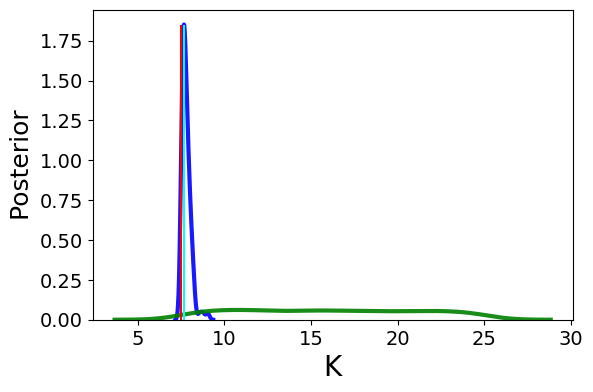

In [148]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    
   
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
    
    ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel('K', fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.show()